### Travis James Smith

## Problem 1
Using code from lecture:

In [201]:
%matplotlib inline
import numpy as np
import torch
torch.set_printoptions(edgeitems=2)

t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_f = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_f = torch.tensor(t_f)

Defining the model and the loss functions. Our model is linear in one dimension, so we have just two parameters (a single weight and a bias).

In [202]:
def model(t_f, w, b):
    return w * t_f + b

def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [203]:
w = torch.ones(1)
b = torch.zeros(1)

t_p = model(t_f, w, b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])

In [204]:
loss = loss_fn(t_p, t_c)
print(loss)

tensor(1763.8846)


Now we need functions to calculate the partial derivates needed for backpropagation:

In [205]:
def dloss_fn(t_p, t_c):
    dsq_diffs = 2 * (t_p - t_c)
    return dsq_diffs

def dmodel_db(t_f, w, b):
    return 1.0

def dmodel_dw(t_f, w, b):
    return t_f

def grad_fn(t_f, t_c, t_p, w, b):
    dloss_dw = dloss_fn(t_p, t_c) * dmodel_dw(t_f, w, b)
    dloss_db = dloss_fn(t_p, t_c) * dmodel_db(t_f, w, b)
    return torch.stack([dloss_dw.mean(), dloss_db.mean()])

And now the training loop, the main component in our parameter learning script:

In [206]:
def training_loop(n_epochs, learning_rate, params, t_f, t_c, print_params=True):
    for epoch in range(1, n_epochs + 1):
        w, b = params
        
        t_p = model(t_f, w, b) # this is forward pass
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_f, t_c, t_p, w, b) # backward pass
        
        params = params - learning_rate * grad
        
        if epoch in {1, 2, 3, 10, 11, 99, 100, 4000, 5000}: # <3>
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            if print_params:
                print(' Params:', params)
                print(' Grad: ', grad)
            
        if epoch in {4, 12, 101}:
            print('...')
            
        if not torch.isfinite(loss).all():
            break # <3>
            
    return params

We run the model below:

In [207]:
t_fn = 0.1 * t_f

params = training_loop(
    n_epochs = 100000,
    learning_rate = 1e-4,
    params = torch.tensor([1.0, 0.0]),
    t_f = t_fn,
    t_c = t_c,
    print_params = False)
params

Epoch 1, Loss 80.364342
Epoch 2, Loss 79.752480
Epoch 3, Loss 79.148026
...
Epoch 10, Loss 75.116219
Epoch 11, Loss 74.567734
...
Epoch 99, Loss 45.087246
Epoch 100, Loss 44.900906
...
Epoch 4000, Loss 26.422493
Epoch 5000, Loss 25.637672


tensor([  4.8012, -14.0978])

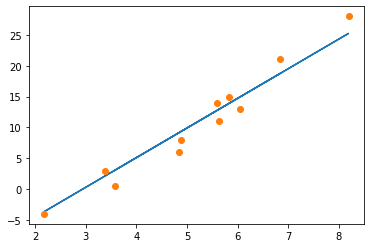

In [208]:
from matplotlib import pyplot as plt

t_p = model(t_fn, *params) # <1>

plt.plot(0.1 * t_f.numpy(), t_p.numpy())
plt.plot(0.1 * t_f.numpy(), t_c.numpy(), 'o')

With 100,000 epochs of our basic gradient descent, we have a pretty nice-looking linear regression.

## Problem 2
Now we can use PyTorch's autograd. Code again borrowed from lecture:

In [209]:
def training_loop(n_epochs, learning_rate, params, t_f, t_c):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None: # Done at any point in the loop
            params.grad.zero_() # before a call to loss.backward()
            
        t_p = model(t_f, *params)
        loss = loss_fn(t_p, t_c)
        loss.backward()
        params = (params - learning_rate * params.grad).detach().requires_grad_()
        
        if epoch % 10000 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
    return params

In [210]:
params = training_loop(
    n_epochs = 100000,
    learning_rate = 1e-4,
    params = torch.tensor([1.0, 0.0], requires_grad=True),
    t_f = t_fn,
    t_c = t_c)
params

Epoch 10000, Loss 22.089724
Epoch 20000, Loss 16.570116
Epoch 30000, Loss 12.640473
Epoch 40000, Loss 9.842770
Epoch 50000, Loss 7.850929
Epoch 60000, Loss 6.432972
Epoch 70000, Loss 5.423423
Epoch 80000, Loss 4.704628
Epoch 90000, Loss 4.192858
Epoch 100000, Loss 3.828507


tensor([  4.8012, -14.0978], requires_grad=True)

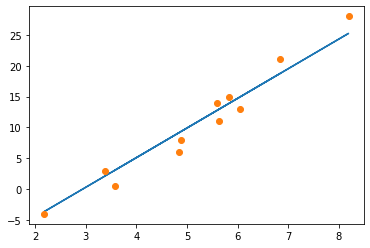

In [211]:
t_p = model(t_fn, *params) # <1>

plt.plot(0.1 * t_f.detach().numpy(), t_p.detach().numpy())
plt.plot(0.1 * t_f.detach().numpy(), t_c.detach().numpy(), 'o')

We got the exact same parameters with PyTorch's autograd as we did with our handwritten gradient descent.

## Problem 3
Now we'll use PyTorch's optimized autograd methods, which should perform better than our unoptimized algorithm:

In [212]:
import torch.optim as optim

In [213]:
def training_loop(n_epochs, optimizer, params, t_f, t_c):
    for epoch in range(1, n_epochs + 1):
        t_p = model(t_f, *params)
        loss = loss_fn(t_p, t_c)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
    return params

### Using stochastic gradient descent (SGD):

In [214]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

training_loop(
    n_epochs = 2000,
    optimizer = optimizer,
    params = params,
    t_f = t_fn,
    t_c = t_c)

Epoch 500, Loss 7.860116
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957697


tensor([  5.2644, -16.7200], requires_grad=True)

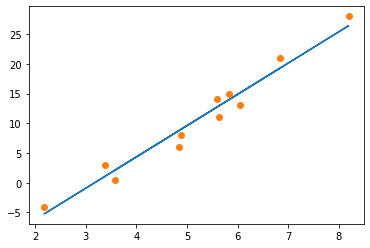

In [215]:
t_p = model(t_fn, *params) # <1>

plt.plot(0.1 * t_f.detach().numpy(), t_p.detach().numpy())
plt.plot(0.1 * t_f.detach().numpy(), t_c.detach().numpy(), 'o')

### Using Adam:

In [216]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-1
optimizer = optim.Adam([params], lr=learning_rate)

training_loop(
    n_epochs = 2000,
    optimizer = optimizer,
    params = params,
    t_f = t_fn,
    t_c = t_c)

Epoch 500, Loss 2.962301
Epoch 1000, Loss 2.927645
Epoch 1500, Loss 2.927646
Epoch 2000, Loss 2.927646


tensor([  5.3677, -17.3048], requires_grad=True)

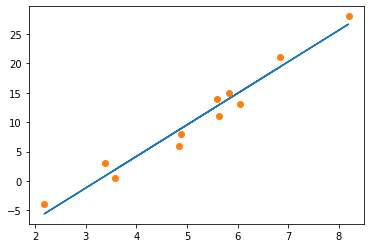

In [217]:
t_p = model(t_fn, *params) # <1>

plt.plot(0.1 * t_f.detach().numpy(), t_p.detach().numpy())
plt.plot(0.1 * t_f.detach().numpy(), t_c.detach().numpy(), 'o')

Both of these optimized gradient descent algorithms performed better in 2,000 epochs than our unoptimized algorithms did in 100,000 epochs. That's a pretty profound difference. 

Adam performed slightly better than vanilla SGD when given a smaller initial learning rate, which is to be expected (since it's an optimized SGD).

## Problem 4
Now we can try splitting our tiny dataset into training and validation subsets:

In [267]:
n_samples = t_f.shape[0]
n_val = int(0.3 * n_samples) # 30% of data for the validation set

shuffled_indices = torch.randperm(n_samples)
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

print(train_indices, val_indices)

tensor([ 2, 10,  5,  0,  7,  8,  1,  4]) tensor([9, 3, 6])


We should get random sets of indices with each run of the above cell. We still need to normalize our data points, which we do below:

In [268]:
train_t_f = t_f[train_indices]
train_t_c = t_c[train_indices]
val_t_f = t_f[val_indices]
val_t_c = t_c[val_indices]

train_t_fn = 0.1 * train_t_f
val_t_fn = 0.1 * val_t_f

In [269]:
class History:
    def __init__(self):
        self.train_loss = np.zeros(3000)
        self.val_loss = np.zeros(3000)

In [270]:
def training_loop(n_epochs, optimizer, params, train_t_f, val_t_f, train_t_c, val_t_c):
    history = History()
    
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_f, *params) # passing model
        train_loss = loss_fn(train_t_p, train_t_c)
        history.train_loss[epoch - 1] = train_loss
        
        val_t_p = model(val_t_f, *params) # <1>
        val_loss = loss_fn(val_t_p, val_t_c)
        history.val_loss[epoch - 1] = val_loss
        
        optimizer.zero_grad()
        train_loss.backward() # The loss function is also passed in
        optimizer.step()
        
        if epoch <= 3 or epoch % 500 == 0:
            print('Epoch {}, Training loss {}, Validation loss {}'.format(epoch, float(train_loss), float(val_loss)))
    return params, history

In [271]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

params, history = training_loop(
    n_epochs = 3000,
    optimizer = optimizer,
    params = params,
    train_t_f = train_t_fn,
    val_t_f = val_t_fn,
    train_t_c = train_t_c,
    val_t_c = val_t_c)
params

Epoch 1, Training loss 55.37225341796875, Validation loss 147.00991821289062
Epoch 2, Training loss 32.00364303588867, Validation loss 82.40554809570312
Epoch 3, Training loss 27.003137588500977, Validation loss 61.030216217041016
Epoch 500, Training loss 8.540688514709473, Validation loss 13.505252838134766
Epoch 1000, Training loss 4.141602993011475, Validation loss 5.5711894035339355
Epoch 1500, Training loss 3.0246410369873047, Validation loss 3.909045457839966
Epoch 2000, Training loss 2.741036891937256, Validation loss 3.6645686626434326
Epoch 2500, Training loss 2.669029712677002, Validation loss 3.691962480545044
Epoch 3000, Training loss 2.650742530822754, Validation loss 3.7440061569213867


tensor([  5.3931, -17.5764], requires_grad=True)

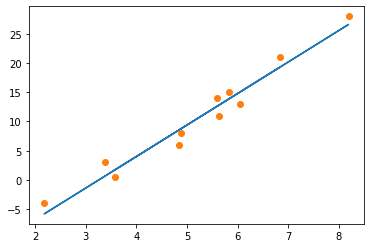

In [272]:
t_p = model(t_fn, *params) # <1>

plt.plot(0.1 * t_f.detach().numpy(), t_p.detach().numpy())
plt.plot(0.1 * t_f.detach().numpy(), t_c.detach().numpy(), 'o')

Let's plot the training and validation losses across epochs:

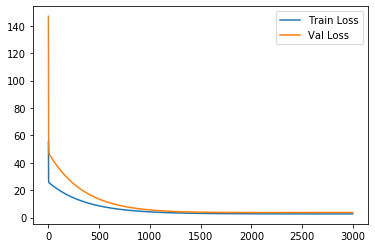

In [273]:
plt.plot(history.train_loss, label="Train Loss")
plt.plot(history.val_loss, label="Val Loss")
plt.legend()

It's hard to see, and our dataset is so small that it's almost trivial, but the validation loss starts to increase around epoch 2,500. This would suggest slight overfitting.